# Vulnerability Exploratory Data Analysis

**Source**: DayDiff daily snapshots of DevGrid vulnerability data  
**Scope**: All tracked assets (vulnerability-category datasets)  
**Database**: `data/daydiff.db` (SQLite)

---

This notebook performs a comprehensive EDA on the vulnerability datasets captured
by DayDiff. It leverages both point-in-time snapshots and daily diff records to
surface patterns that standard vulnerability scanners cannot provide on their own.

**Sections**:
1. Setup & Data Loading
2. Data Quality Assessment
3. Univariate Distributions
4. Temporal Analysis
5. Bivariate / Cross-Tabulations
6. Change Dynamics
7. Per-Asset Comparison
8. Risk Scoring
9. Executive Summary

## 1. Setup & Data Loading

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

from helpers import (
    load_latest_snapshot,
    load_all_snapshots,
    load_diff_summaries,
    load_diff_items,
    load_population_trend,
    SEVERITY_ORDER,
    SEVERITY_COLORS,
    STATUS_ORDER,
    SCAN_TYPE_ORDER,
)

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({"figure.dpi": 120, "figure.figsize": (10, 5), "font.size": 11})
sns.set_palette("muted")

pd.set_option("display.max_columns", 40)
pd.set_option("display.max_colwidth", 60)

Matplotlib is building the font cache; this may take a moment.


In [2]:
df = load_latest_snapshot()

date_cols = ["openDate", "closeDate", "dueDate", "atRiskDate", "createdAt", "updatedAt", "deleted_at"]
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce", utc=True)

df["severity"] = pd.Categorical(df["severity"], categories=SEVERITY_ORDER, ordered=True)
df["status"] = pd.Categorical(df["status"], categories=STATUS_ORDER, ordered=True)

print(f"Snapshot date : {df['fetched_date'].iloc[0]}")
print(f"Total vulns   : {len(df):,}")
print(f"Assets tracked: {df['dataset_name'].nunique()}")
print(f"Columns       : {df.shape[1]}")
print()
df["dataset_name"].value_counts().rename("vuln_count").to_frame()

Snapshot date : 2026-02-18
Total vulns   : 310,289
Assets tracked: 3
Columns       : 269



,vuln_count
dataset_name,
vulns-Digital One LFI (12430),192744
vulns-Digital One Flex (17040),102620
vulns-Consumer e-Banking Services (2466),14925


In [3]:
diff_summaries = load_diff_summaries()
diff_items = load_diff_items()
pop_trend = load_population_trend()

print(f"Diff summaries : {len(diff_summaries):,} rows  ({diff_summaries['to_date'].nunique()} dates)")
print(f"Diff items     : {len(diff_items):,} row-level changes")
print(f"Population pts : {len(pop_trend):,}")
df.head(3)

Diff summaries : 3 rows  (1 dates)
Diff items     : 64,366 row-level changes
Population pts : 6


,row_key,fetched_date,dataset_name,id,name,description,originatingSystem,originatingSystemId,originatingSystemUrl,scanType,severity,status,location,solution,openDate,closeDate,vulnerableId,vulnerableType,vulnerabilityProjectId,dueDate,...,attributes.close_notes,attributes.resolution_reason,attributes.close_reason,attributes.avi_description,attributes.avi_category_name,attributes.cwe_primary,attributes.cwe_ids_array,attributes.cwe_names_array,attributes.u_legacy_vulnerability_id,attributes.change_approval.link,attributes.change_approval.value,location.server,attributes.u_summary,attributes.u_issue_type,attributes.u_cvss_vector,attributes.cvss_base_score,attributes.u_cvss_base_score,attributes.u_steps_to_reproduce,attributes.u_source_engagement_id,attributes.u_rmis_request_id
0,00016e55-e332-448a-83fb-ce4ebb94b92c,2026-02-18,vulns-Digital One Flex (17040),00016e55-e332-448a-83fb-ce4ebb94b92c,R7-microsoft-windows-cve-2026-20936 detected on PDC2WDFT...,<p></p><p>Vulnerable OS: Microsoft Windows Server 2022 2...,RAPID7 via ServiceNow,VIT513214209,None,infrastructure,LOW,detected,NaN,<p></p><p>Vulnerable OS: Microsoft Windows Server 2022 2...,2026-01-15 00:00:00+00:00,NaT,7d53603e-0973-437d-a3da-a129cb8108ef,entity,None,2026-04-15 00:00:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0001efcf-3d1a-4676-94b6-b545c717efc8,2026-02-18,vulns-Digital One Flex (17040),0001efcf-3d1a-4676-94b6-b545c717efc8,R7-microsoft-windows-cve-2026-20832 detected on LRK1WDFT...,<p></p><p>Vulnerable OS: Microsoft Windows Server 2022 2...,RAPID7 via ServiceNow,VIT513221448,None,infrastructure,LOW,resolved,NaN,<p></p><p>Vulnerable OS: Microsoft Windows Server 2022 2...,2026-01-15 00:00:00+00:00,2026-01-25 04:40:45+00:00,7d53603e-0973-437d-a3da-a129cb8108ef,entity,None,2026-05-15 00:00:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0001f97e-55e1-4c75-a242-50a62cbc3773,2026-02-18,vulns-Digital One Flex (17040),0001f97e-55e1-4c75-a242-50a62cbc3773,R7-microsoft-windows-cve-2026-20837 detected on PDC2WDO1...,<p></p><p>Vulnerable OS: Microsoft Windows Server 2019 S...,RAPID7 via ServiceNow,VIT512555265,None,infrastructure,LOW,resolved,NaN,<p></p><p>Vulnerable OS: Microsoft Windows Server 2019 S...,2026-01-15 00:00:00+00:00,2026-02-05 23:50:46+00:00,7d53603e-0973-437d-a3da-a129cb8108ef,entity,None,2026-04-15 00:00:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Quality Assessment

Check completeness, type validity, duplicates, and schema consistency across assets.

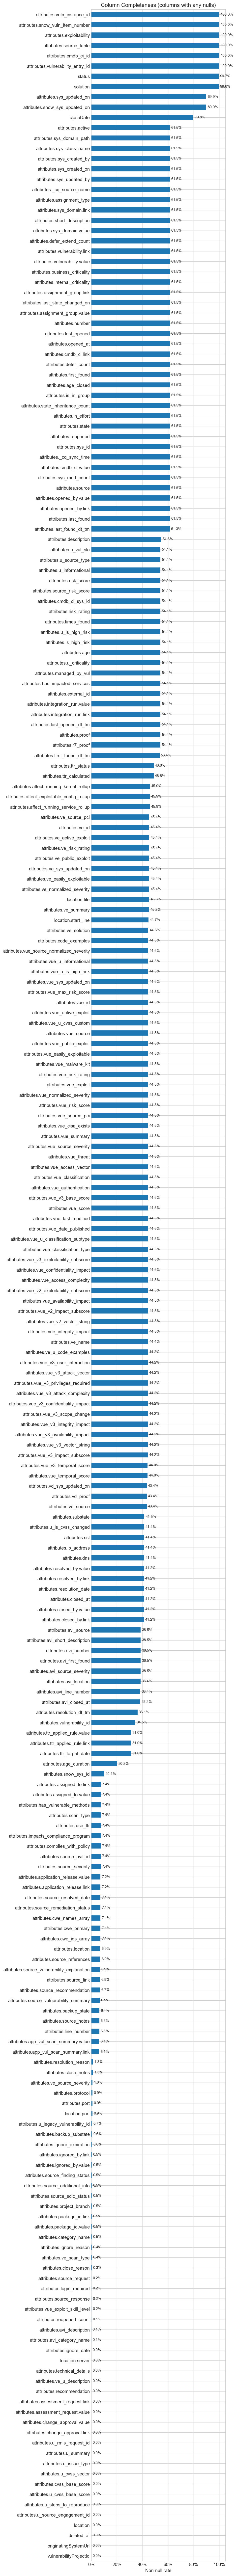

In [4]:
# --- Completeness: percent non-null per column ---
completeness = df.notna().mean().sort_values()
cols_with_nulls = completeness[completeness < 1.0]

fig, ax = plt.subplots(figsize=(8, max(4, len(cols_with_nulls) * 0.35)))
cols_with_nulls.plot.barh(ax=ax, color="#1f77b4")
ax.set_xlim(0, 1.05)
ax.xaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.set_xlabel("Non-null rate")
ax.set_title("Column Completeness (columns with any nulls)")
for i, v in enumerate(cols_with_nulls):
    ax.text(v + 0.01, i, f"{v:.1%}", va="center", fontsize=9)
plt.tight_layout()
plt.show()

In [5]:
# --- Type validation: unexpected values in categorical fields ---
expected = {
    "severity": set(SEVERITY_ORDER),
    "status": set(STATUS_ORDER),
    "scanType": set(SCAN_TYPE_ORDER),
}

for col, valid in expected.items():
    if col not in df.columns:
        print(f"  MISSING column: {col}")
        continue
    actual = set(df[col].dropna().unique())
    unexpected = actual - valid
    if unexpected:
        print(f"  WARNING  {col}: unexpected values {unexpected}")
    else:
        print(f"  OK       {col}: {sorted(actual)}")

# --- Duplicate originatingSystemId check ---
if "originatingSystemId" in df.columns:
    dup_count = df["originatingSystemId"].dropna().duplicated().sum()
    print(f"\n  Duplicate originatingSystemId values: {dup_count:,}")

  OK       severity: ['CRITICAL', 'HIGH', 'INFO', 'LOW', 'MEDIUM']
  OK       status: ['detected', 'resolved']
  WARNING  scanType: unexpected values {'infrastructure', 'Unknown', 'pen_test'}

  Duplicate originatingSystemId values: 26,662


In [6]:
# --- Schema drift: compare columns present per asset ---
schema_by_asset = {}
for name, grp in df.groupby("dataset_name"):
    non_null_cols = set(grp.columns[grp.notna().any()])
    schema_by_asset[name] = non_null_cols

all_cols = set.union(*schema_by_asset.values())
shared_cols = set.intersection(*schema_by_asset.values())
drift_cols = all_cols - shared_cols

if drift_cols:
    print("Schema drift detected — columns not present in every asset:")
    for col in sorted(drift_cols):
        present_in = [n for n, s in schema_by_asset.items() if col in s]
        print(f"  {col}: only in {present_in}")
else:
    print(f"No schema drift: all {len(shared_cols)} columns consistent across {len(schema_by_asset)} assets.")

Schema drift detected — columns not present in every asset:
  attributes.avi_category_name: only in ['vulns-Digital One Flex (17040)', 'vulns-Digital One LFI (12430)']
  attributes.avi_description: only in ['vulns-Digital One Flex (17040)', 'vulns-Digital One LFI (12430)']
  attributes.avi_line_number: only in ['vulns-Digital One Flex (17040)', 'vulns-Digital One LFI (12430)']
  attributes.close_notes: only in ['vulns-Digital One Flex (17040)', 'vulns-Digital One LFI (12430)']
  attributes.cvss_base_score: only in ['vulns-Digital One LFI (12430)']
  attributes.resolution_reason: only in ['vulns-Digital One Flex (17040)', 'vulns-Digital One LFI (12430)']
  attributes.u_cvss_base_score: only in ['vulns-Digital One LFI (12430)']
  attributes.u_cvss_vector: only in ['vulns-Digital One LFI (12430)']
  attributes.u_issue_type: only in ['vulns-Digital One LFI (12430)']
  attributes.u_rmis_request_id: only in ['vulns-Consumer e-Banking Services (2466)']
  attributes.u_source_engagement_id: onl

## 3. Univariate Distributions

Point-in-time view of the current vulnerability landscape across all tracked assets.

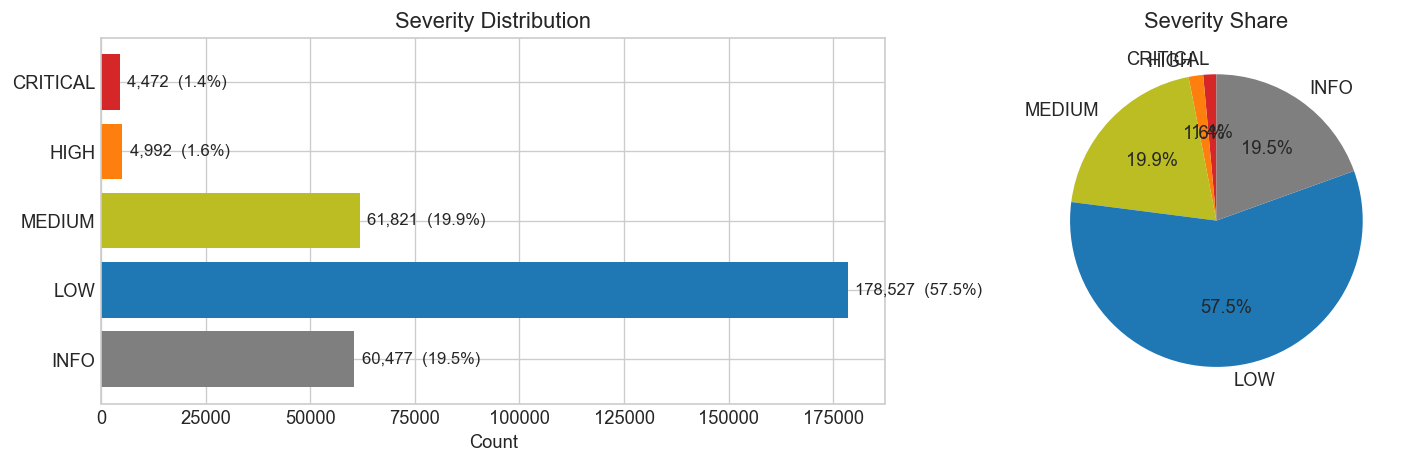

In [7]:
# --- Severity distribution ---
sev_counts = df["severity"].value_counts().reindex(SEVERITY_ORDER).fillna(0).astype(int)
sev_pct = sev_counts / sev_counts.sum()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [2, 1]})

bars = axes[0].barh(
    sev_counts.index,
    sev_counts.values,
    color=[SEVERITY_COLORS[s] for s in sev_counts.index],
)
for bar, cnt, pct in zip(bars, sev_counts.values, sev_pct.values):
    axes[0].text(bar.get_width() + max(sev_counts) * 0.01, bar.get_y() + bar.get_height() / 2,
                 f"{cnt:,}  ({pct:.1%})", va="center", fontsize=10)
axes[0].set_xlabel("Count")
axes[0].set_title("Severity Distribution")
axes[0].invert_yaxis()

axes[1].pie(
    sev_counts.values,
    labels=sev_counts.index,
    colors=[SEVERITY_COLORS[s] for s in sev_counts.index],
    autopct="%1.1f%%",
    startangle=90,
)
axes[1].set_title("Severity Share")
plt.tight_layout()
plt.show()

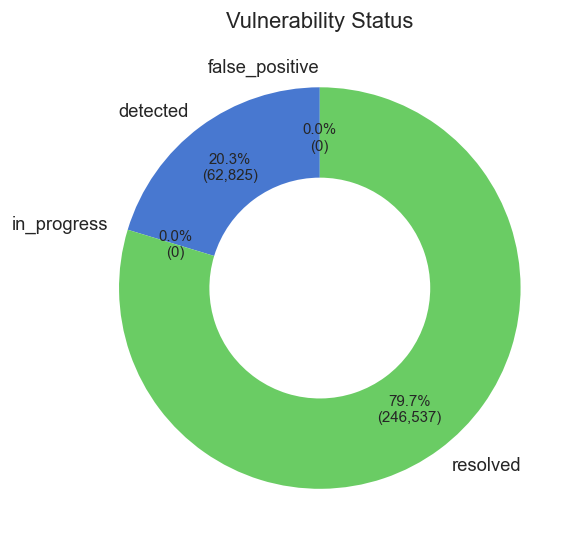

In [8]:
# --- Status distribution (donut chart) ---
status_counts = df["status"].value_counts().reindex(STATUS_ORDER).fillna(0).astype(int)
status_colors = sns.color_palette("muted", len(status_counts))

fig, ax = plt.subplots(figsize=(5, 5))
wedges, texts, autotexts = ax.pie(
    status_counts.values,
    labels=status_counts.index,
    colors=status_colors,
    autopct=lambda p: f"{p:.1f}%\n({int(round(p * sum(status_counts) / 100)):,})",
    startangle=90,
    pctdistance=0.75,
    wedgeprops=dict(width=0.45),
)
for t in autotexts:
    t.set_fontsize(9)
ax.set_title("Vulnerability Status")
plt.tight_layout()
plt.show()

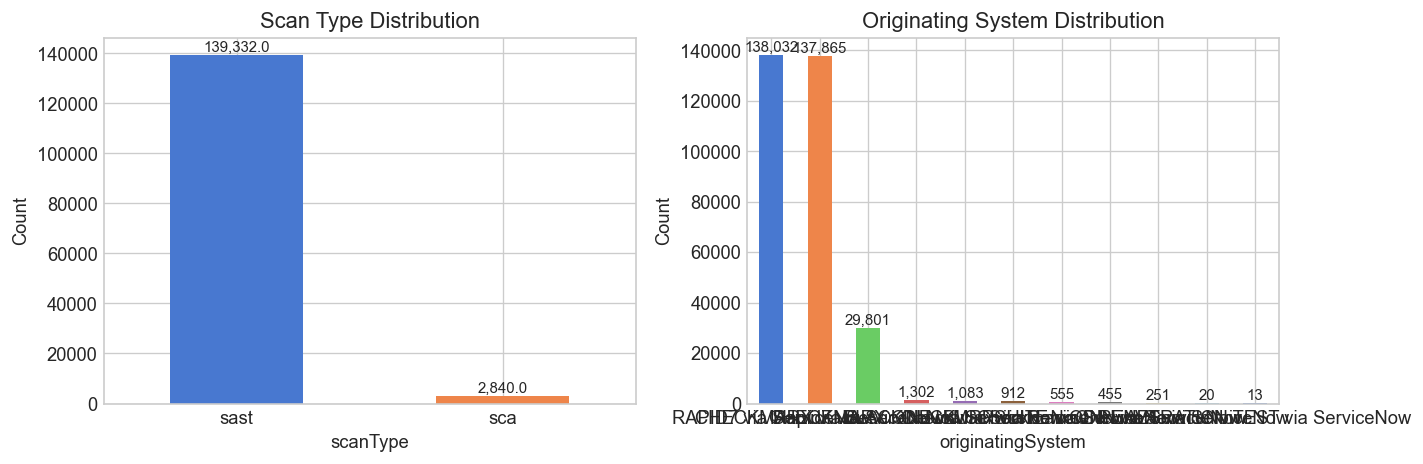

In [9]:
# --- Scan Type & Originating System side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

if "scanType" in df.columns:
    scan_counts = df["scanType"].value_counts().reindex(SCAN_TYPE_ORDER).dropna()
    scan_counts.plot.bar(ax=axes[0], color=sns.color_palette("muted", len(scan_counts)))
    axes[0].set_title("Scan Type Distribution")
    axes[0].set_ylabel("Count")
    axes[0].tick_params(axis="x", rotation=0)
    for i, v in enumerate(scan_counts):
        axes[0].text(i, v + max(scan_counts) * 0.01, f"{v:,}", ha="center", fontsize=9)

if "originatingSystem" in df.columns:
    sys_counts = df["originatingSystem"].value_counts()
    sys_counts.plot.bar(ax=axes[1], color=sns.color_palette("muted", len(sys_counts)))
    axes[1].set_title("Originating System Distribution")
    axes[1].set_ylabel("Count")
    axes[1].tick_params(axis="x", rotation=0)
    for i, v in enumerate(sys_counts):
        axes[1].text(i, v + max(sys_counts) * 0.01, f"{v:,}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()

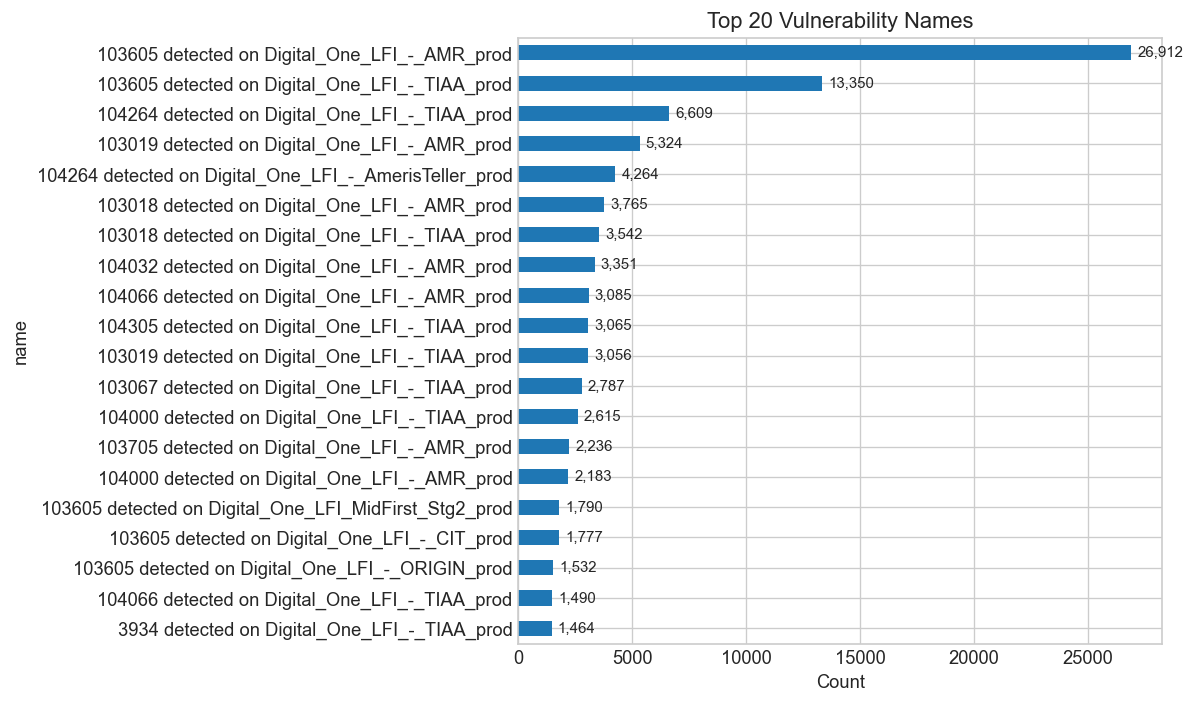

In [10]:
# --- Top Vulnerability Names ---
top_n = 20
name_counts = df["name"].value_counts().head(top_n)

fig, ax = plt.subplots(figsize=(10, max(4, top_n * 0.3)))
name_counts.iloc[::-1].plot.barh(ax=ax, color="#1f77b4")
ax.set_xlabel("Count")
ax.set_title(f"Top {top_n} Vulnerability Names")
for i, v in enumerate(name_counts.iloc[::-1]):
    ax.text(v + max(name_counts) * 0.01, i, f"{v:,}", va="center", fontsize=9)
plt.tight_layout()
plt.show()

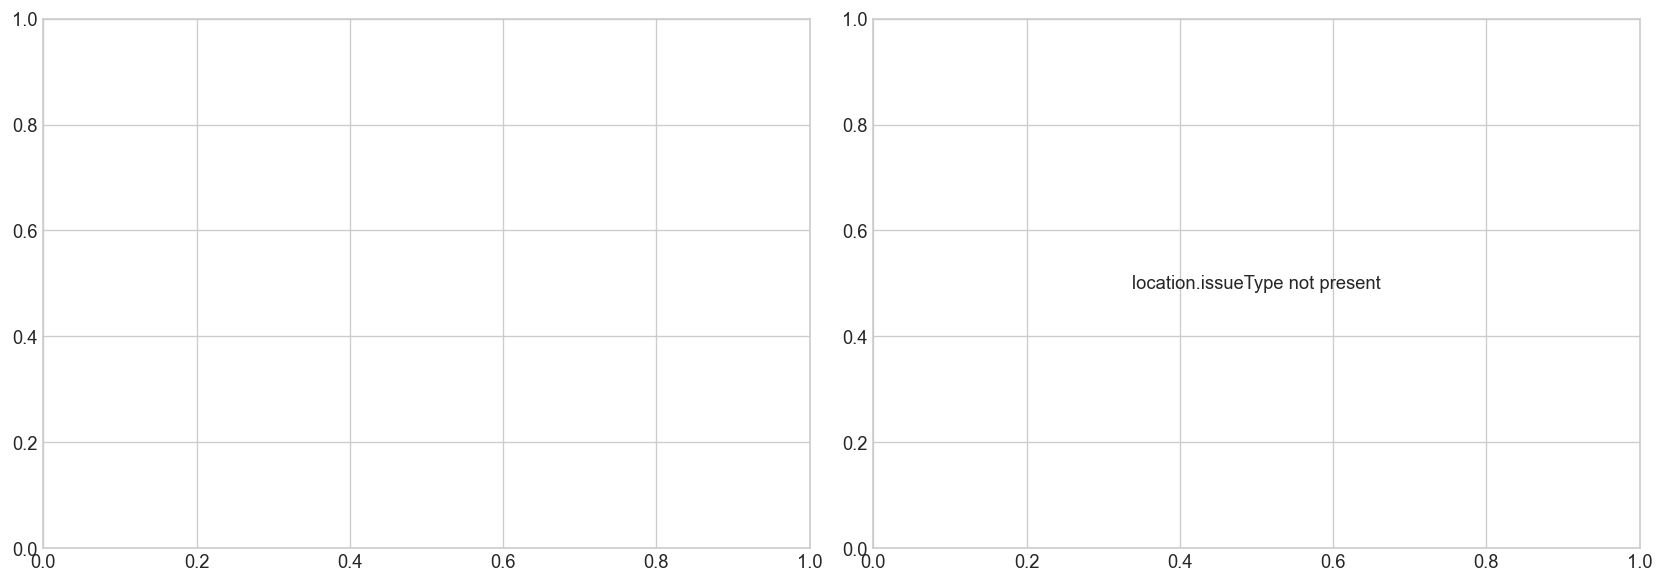

In [11]:
# --- Top Affected Files & Issue Type ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if "location.fileName" in df.columns:
    file_counts = df["location.fileName"].value_counts().head(15)
    file_counts.iloc[::-1].plot.barh(ax=axes[0], color="#ff7f0e")
    axes[0].set_xlabel("Count")
    axes[0].set_title("Top 15 Affected Files")

if "location.issueType" in df.columns:
    issue_counts = df["location.issueType"].value_counts()
    issue_counts.plot.bar(ax=axes[1], color=sns.color_palette("muted", len(issue_counts)))
    axes[1].set_title("Issue Type Breakdown")
    axes[1].set_ylabel("Count")
    axes[1].tick_params(axis="x", rotation=45)
else:
    axes[1].text(0.5, 0.5, "location.issueType not present", ha="center", va="center",
                 transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

## 4. Temporal Analysis

How long have vulnerabilities been open? How fast are they being resolved?
Are we meeting SLA deadlines?

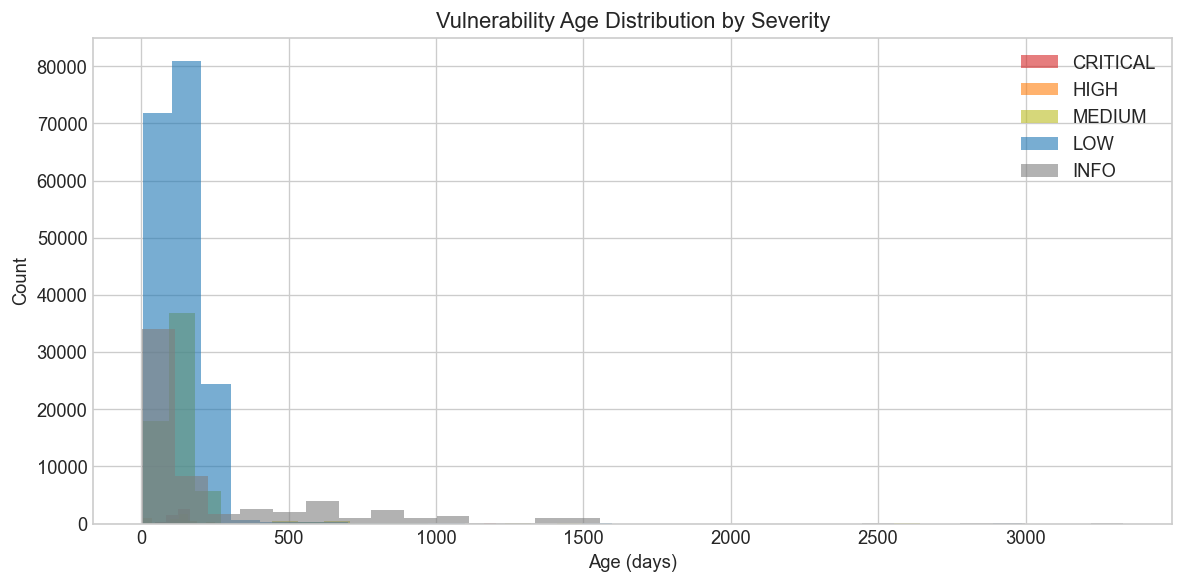

Age summary (days):
             count   mean    50%     max
severity                                
CRITICAL    4472.0  129.2  134.7  1203.7
HIGH        4992.0  157.2  145.7   922.7
MEDIUM     61821.0  127.9  124.7  2640.5
LOW       178527.0  127.8  124.7  2987.7
INFO       60477.0  271.5   96.7  3331.7


In [12]:
# --- Vulnerability age distribution ---
now = pd.Timestamp.now(tz="UTC")

if "openDate" in df.columns:
    df["age_days"] = (now - df["openDate"]).dt.total_seconds() / 86400

    fig, ax = plt.subplots(figsize=(10, 5))
    for sev in SEVERITY_ORDER:
        subset = df.loc[df["severity"] == sev, "age_days"].dropna()
        if len(subset) > 0:
            ax.hist(subset, bins=30, alpha=0.6, label=sev, color=SEVERITY_COLORS[sev])
    ax.set_xlabel("Age (days)")
    ax.set_ylabel("Count")
    ax.set_title("Vulnerability Age Distribution by Severity")
    ax.legend()
    plt.tight_layout()
    plt.show()

    print("Age summary (days):")
    print(df.groupby("severity", observed=True)["age_days"].describe()[["count", "mean", "50%", "max"]].round(1))

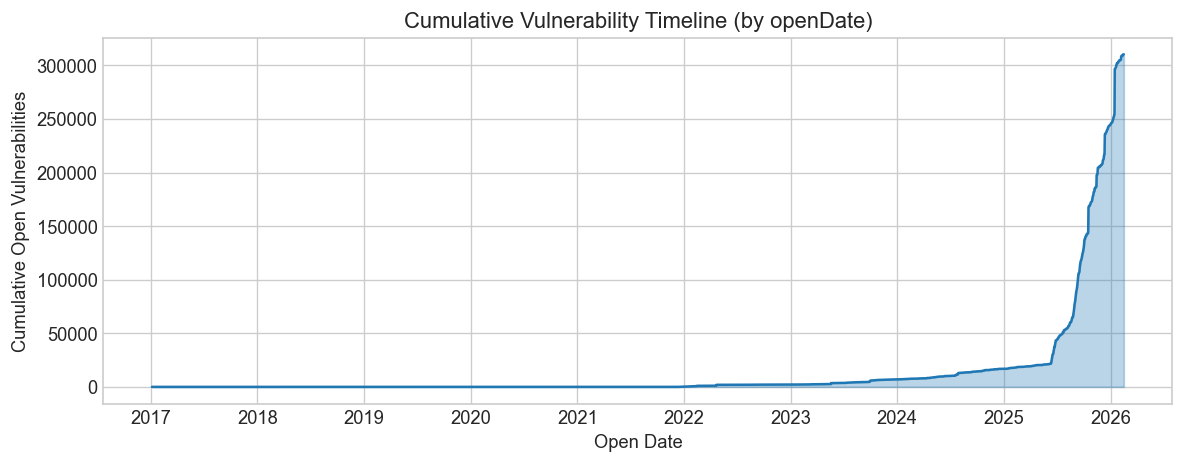

In [13]:
# --- Open-date timeline: cumulative open vulnerabilities ---
if "openDate" in df.columns:
    open_ts = df["openDate"].dropna().dt.normalize().value_counts().sort_index().cumsum()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.fill_between(open_ts.index, open_ts.values, alpha=0.3, color="#1f77b4")
    ax.plot(open_ts.index, open_ts.values, color="#1f77b4", linewidth=1.5)
    ax.set_xlabel("Open Date")
    ax.set_ylabel("Cumulative Open Vulnerabilities")
    ax.set_title("Cumulative Vulnerability Timeline (by openDate)")
    plt.tight_layout()
    plt.show()

/var/folders/x5/wfzgbqg53cz74xrtjrb2h3mm0000gn/T/ipykernel_97817/3209530836.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_box, labels=sev_present, patch_artist=True, vert=True)


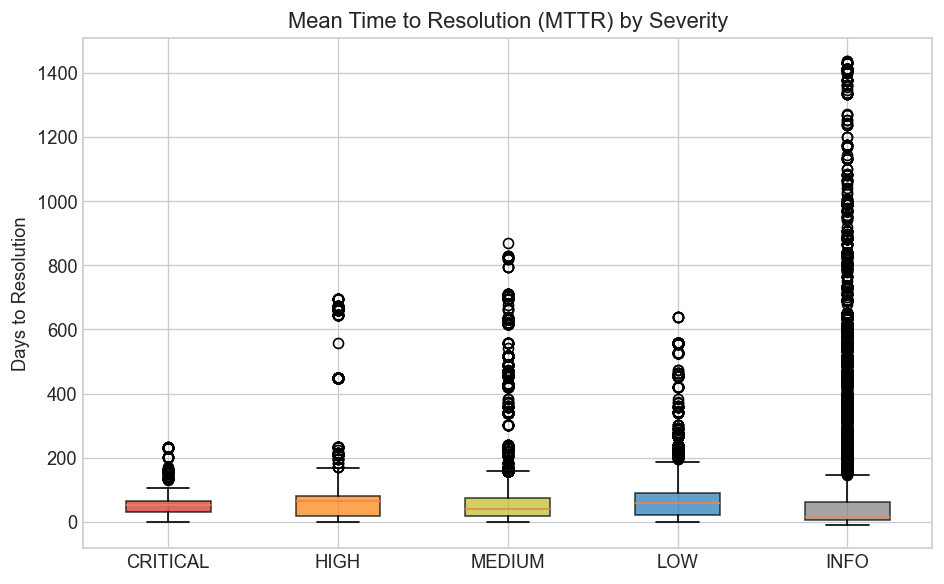

           count   mean  median
severity                       
CRITICAL    4345   49.0    51.5
HIGH        4411   81.7    64.0
MEDIUM     49562   58.7    38.4
LOW       162123   65.3    58.5
INFO       27023  100.6    13.7


In [14]:
# --- Mean Time to Resolution (MTTR) ---
closed = df.dropna(subset=["closeDate", "openDate"]).copy()
if len(closed) > 0:
    closed["mttr_days"] = (closed["closeDate"] - closed["openDate"]).dt.total_seconds() / 86400

    fig, ax = plt.subplots(figsize=(8, 5))
    sev_present = [s for s in SEVERITY_ORDER if s in closed["severity"].values]
    data_for_box = [closed.loc[closed["severity"] == s, "mttr_days"].values for s in sev_present]
    bp = ax.boxplot(data_for_box, labels=sev_present, patch_artist=True, vert=True)
    for patch, sev in zip(bp["boxes"], sev_present):
        patch.set_facecolor(SEVERITY_COLORS.get(sev, "#999"))
        patch.set_alpha(0.7)
    ax.set_ylabel("Days to Resolution")
    ax.set_title("Mean Time to Resolution (MTTR) by Severity")
    plt.tight_layout()
    plt.show()

    print(closed.groupby("severity", observed=True)["mttr_days"].agg(["count", "mean", "median"]).round(1))
else:
    print("No resolved vulnerabilities with both openDate and closeDate — MTTR cannot be computed.")

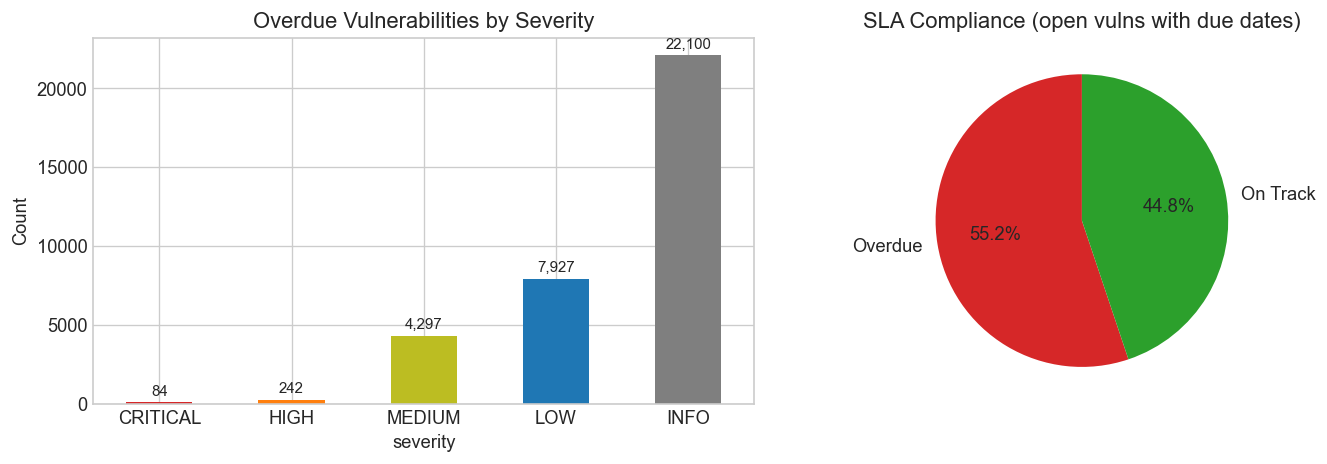

Vulnerabilities past at-risk date but still open: 38,816


In [15]:
# --- SLA compliance: overdue analysis ---
open_vulns = df[df["status"].isin(["detected", "in_progress"])].copy()

if "dueDate" in df.columns and open_vulns["dueDate"].notna().any():
    open_vulns["overdue"] = open_vulns["dueDate"] < now
    open_vulns["days_overdue"] = (now - open_vulns["dueDate"]).dt.total_seconds() / 86400
    open_vulns.loc[~open_vulns["overdue"], "days_overdue"] = 0

    overdue_by_sev = (
        open_vulns[open_vulns["overdue"]]
        .groupby("severity", observed=True)
        .size()
        .reindex(SEVERITY_ORDER, fill_value=0)
    )

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    overdue_by_sev.plot.bar(
        ax=axes[0],
        color=[SEVERITY_COLORS[s] for s in overdue_by_sev.index],
    )
    axes[0].set_title("Overdue Vulnerabilities by Severity")
    axes[0].set_ylabel("Count")
    axes[0].tick_params(axis="x", rotation=0)
    for i, v in enumerate(overdue_by_sev):
        if v > 0:
            axes[0].text(i, v + max(1, max(overdue_by_sev) * 0.02), f"{v:,}", ha="center", fontsize=9)

    total_open = len(open_vulns[open_vulns["dueDate"].notna()])
    total_overdue = open_vulns["overdue"].sum()
    axes[1].pie(
        [total_overdue, total_open - total_overdue],
        labels=["Overdue", "On Track"],
        colors=["#d62728", "#2ca02c"],
        autopct="%1.1f%%",
        startangle=90,
    )
    axes[1].set_title("SLA Compliance (open vulns with due dates)")
    plt.tight_layout()
    plt.show()

    # At-risk analysis
    if "atRiskDate" in df.columns and open_vulns["atRiskDate"].notna().any():
        at_risk = open_vulns[open_vulns["atRiskDate"] < now]
        print(f"Vulnerabilities past at-risk date but still open: {len(at_risk):,}")
else:
    print("No dueDate data available for SLA analysis.")

## 5. Bivariate / Cross-Tabulations

How do severity, scan type, originating system, and file location interact?

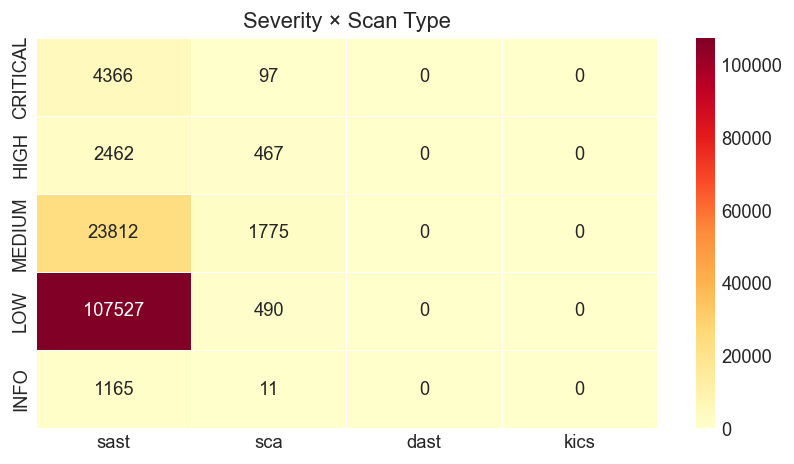

In [16]:
# --- Severity x Scan Type heatmap ---
if "scanType" in df.columns:
    ct = pd.crosstab(df["severity"], df["scanType"])
    ct = ct.reindex(index=SEVERITY_ORDER, columns=SCAN_TYPE_ORDER).fillna(0).astype(int)

    fig, ax = plt.subplots(figsize=(7, 4))
    sns.heatmap(ct, annot=True, fmt="d", cmap="YlOrRd", linewidths=0.5, ax=ax)
    ax.set_title("Severity × Scan Type")
    ax.set_ylabel("")
    ax.set_xlabel("")
    plt.tight_layout()
    plt.show()

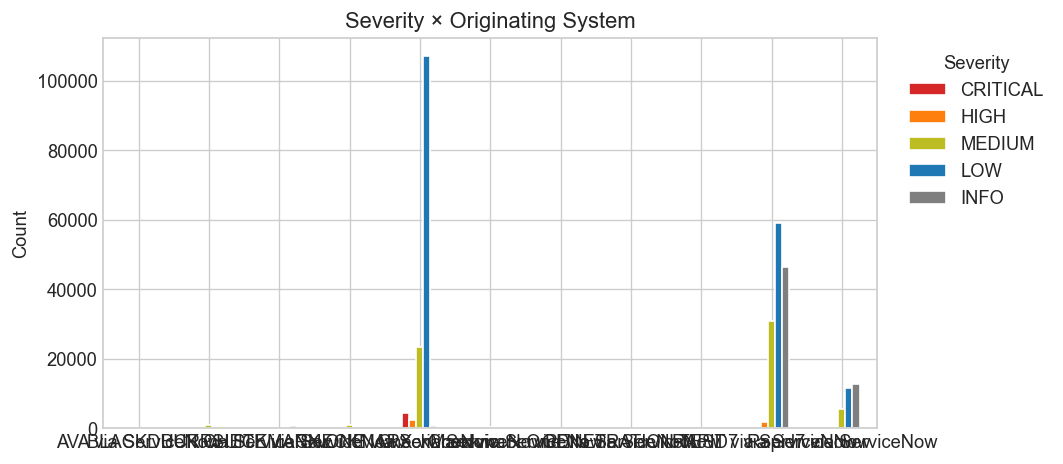

In [17]:
# --- Severity x Originating System (grouped bar) ---
if "originatingSystem" in df.columns:
    ct2 = pd.crosstab(df["originatingSystem"], df["severity"])
    ct2 = ct2.reindex(columns=SEVERITY_ORDER).fillna(0).astype(int)

    ct2.plot.bar(
        color=[SEVERITY_COLORS[s] for s in ct2.columns],
        figsize=(9, 4),
        edgecolor="white",
    )
    plt.title("Severity × Originating System")
    plt.ylabel("Count")
    plt.xlabel("")
    plt.legend(title="Severity", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

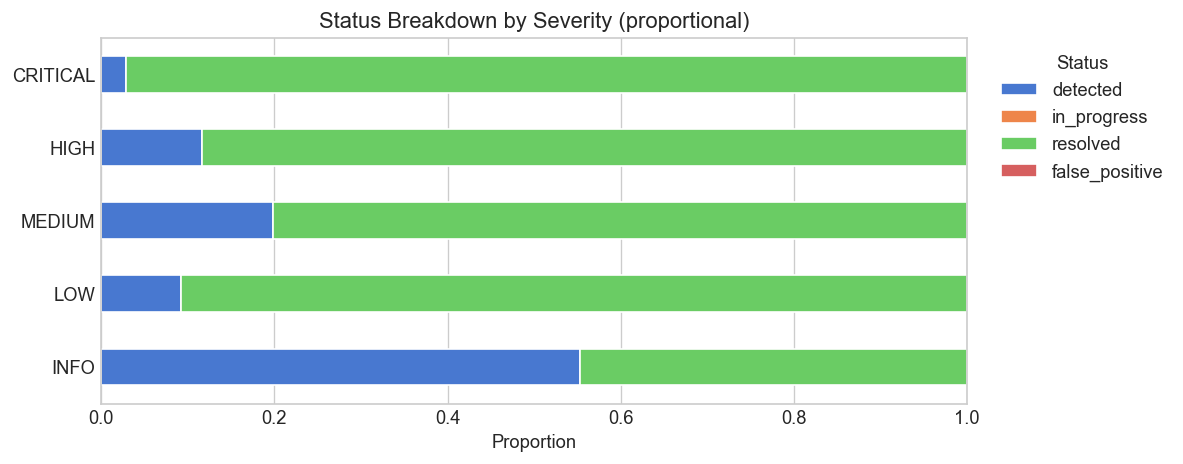

In [18]:
# --- Status x Severity (stacked bar — resolution rates) ---
ct3 = pd.crosstab(df["severity"], df["status"])
ct3 = ct3.reindex(index=SEVERITY_ORDER, columns=STATUS_ORDER).fillna(0).astype(int)
ct3_pct = ct3.div(ct3.sum(axis=1), axis=0)

ct3_pct.plot.barh(
    stacked=True,
    figsize=(10, 4),
    color=sns.color_palette("muted", len(STATUS_ORDER)),
    edgecolor="white",
)
plt.title("Status Breakdown by Severity (proportional)")
plt.xlabel("Proportion")
plt.ylabel("")
plt.legend(title="Status", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xlim(0, 1)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [19]:
# --- File hotspot bubble chart (interactive) ---
if "location.fileName" in df.columns:
    sev_weight = {"CRITICAL": 5, "HIGH": 4, "MEDIUM": 3, "LOW": 2, "INFO": 1}
    hotspot = (
        df.groupby(["location.fileName", "severity"], observed=True)
        .size()
        .reset_index(name="count")
    )
    hotspot["weight"] = hotspot["severity"].map(sev_weight).fillna(1)
    top_files = hotspot.groupby("location.fileName")["count"].sum().nlargest(12).index
    hotspot = hotspot[hotspot["location.fileName"].isin(top_files)]

    fig = px.scatter(
        hotspot,
        x="location.fileName",
        y="severity",
        size="count",
        color="severity",
        color_discrete_map=SEVERITY_COLORS,
        category_orders={"severity": SEVERITY_ORDER},
        title="File Hotspots (top 12 files × severity, size = count)",
        size_max=35,
    )
    fig.update_layout(xaxis_tickangle=-45, height=450)
    fig.show()

/Users/kylezapcic/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning:

urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020



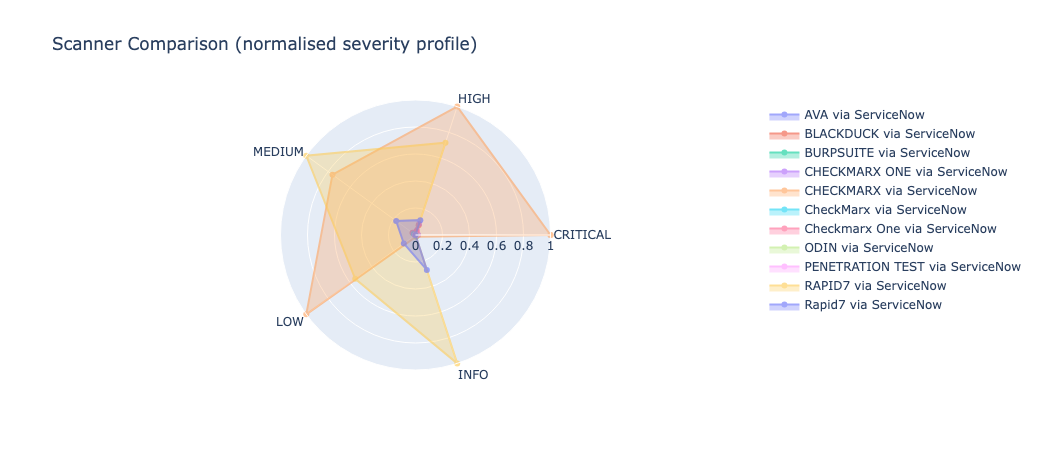

In [20]:
# --- Scanner tool comparison: radar chart ---
if "originatingSystem" in df.columns:
    radar_data = pd.crosstab(df["originatingSystem"], df["severity"])
    radar_data = radar_data.reindex(columns=SEVERITY_ORDER).fillna(0)
    # Normalise each severity column to 0-1 for radar comparability
    radar_norm = radar_data.div(radar_data.max(axis=0), axis=1).fillna(0)

    categories = list(radar_norm.columns)
    fig = go.Figure()
    for system in radar_norm.index:
        vals = radar_norm.loc[system].tolist()
        vals.append(vals[0])  # close the polygon
        fig.add_trace(go.Scatterpolar(
            r=vals,
            theta=categories + [categories[0]],
            fill="toself",
            name=system,
            opacity=0.6,
        ))

    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
        title="Scanner Comparison (normalised severity profile)",
        height=450,
    )
    fig.show()

## 6. Change Dynamics

This section leverages DayDiff's daily diff engine — the unique value-add that no
standard vulnerability scanner provides. It reveals how the vulnerability landscape
*changes* day over day: churn rates, field volatility, severity drift, and data
stability signals.

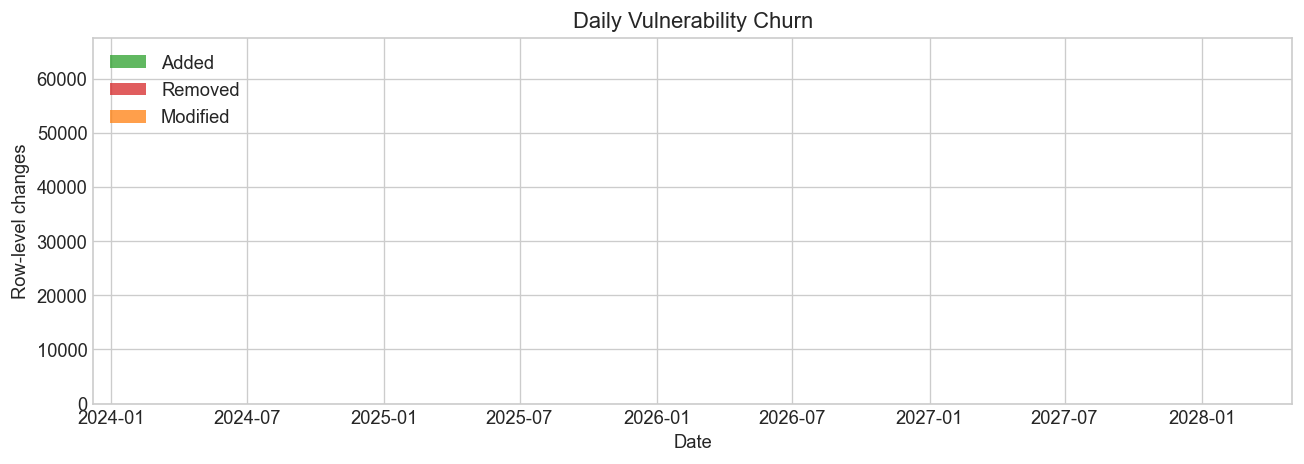

In [21]:
# --- Daily churn: stacked area chart ---
if not diff_summaries.empty:
    churn = diff_summaries.groupby("to_date")[["added_count", "removed_count", "modified_count"]].sum()
    churn.index = pd.to_datetime(churn.index)

    fig, ax = plt.subplots(figsize=(11, 4))
    ax.stackplot(
        churn.index,
        churn["added_count"],
        churn["removed_count"],
        churn["modified_count"],
        labels=["Added", "Removed", "Modified"],
        colors=["#2ca02c", "#d62728", "#ff7f0e"],
        alpha=0.75,
    )
    ax.set_xlabel("Date")
    ax.set_ylabel("Row-level changes")
    ax.set_title("Daily Vulnerability Churn")
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
else:
    print("No diff summaries available.")

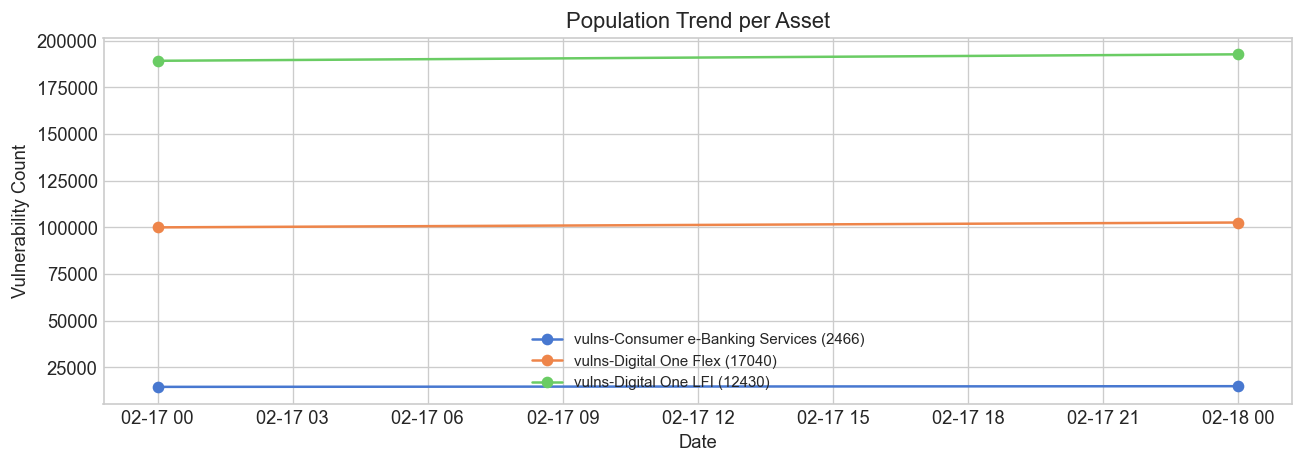

In [22]:
# --- Population trend: total vuln count per asset over time ---
if not pop_trend.empty:
    pop_trend["fetched_date"] = pd.to_datetime(pop_trend["fetched_date"])
    fig, ax = plt.subplots(figsize=(11, 4))
    for name, grp in pop_trend.groupby("dataset_name"):
        ax.plot(grp["fetched_date"], grp["row_count"], marker="o", label=name, linewidth=1.5)
    ax.set_xlabel("Date")
    ax.set_ylabel("Vulnerability Count")
    ax.set_title("Population Trend per Asset")
    ax.legend(fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No population trend data.")

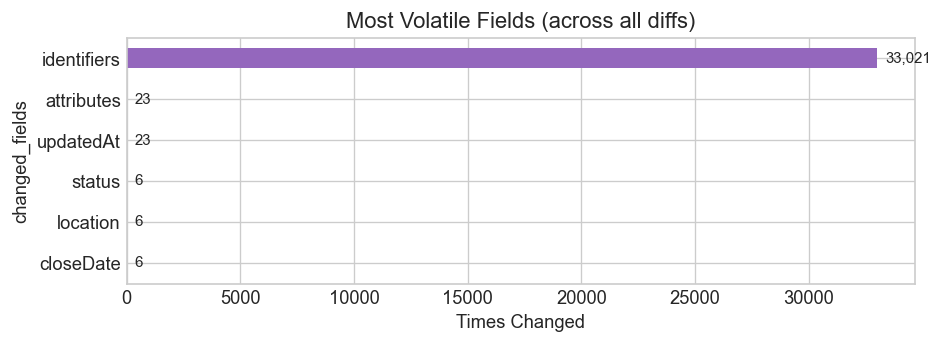

In [23]:
# --- Field volatility: which fields change most often? ---
if not diff_items.empty:
    modified = diff_items[diff_items["change_type"] == "modified"]
    all_fields = modified["changed_fields"].explode()
    field_freq = all_fields.value_counts().head(15)

    if len(field_freq) > 0:
        fig, ax = plt.subplots(figsize=(8, max(3, len(field_freq) * 0.35)))
        field_freq.iloc[::-1].plot.barh(ax=ax, color="#9467bd")
        ax.set_xlabel("Times Changed")
        ax.set_title("Most Volatile Fields (across all diffs)")
        for i, v in enumerate(field_freq.iloc[::-1]):
            ax.text(v + max(field_freq) * 0.01, i, f"{v:,}", va="center", fontsize=9)
        plt.tight_layout()
        plt.show()
    else:
        print("No modified rows found in diff items.")
else:
    print("No diff items available.")

In [24]:
# --- Severity drift: transition matrix (upgrades vs downgrades) ---
if not diff_items.empty:
    sev_changes = modified[modified["changed_fields"].apply(lambda x: "severity" in x)].copy()
    if len(sev_changes) > 0:
        sev_changes["old_sev"] = sev_changes["field_changes"].apply(
            lambda fc: fc.get("severity", {}).get("old", "unknown")
        )
        sev_changes["new_sev"] = sev_changes["field_changes"].apply(
            lambda fc: fc.get("severity", {}).get("new", "unknown")
        )
        transition_matrix = pd.crosstab(
            sev_changes["old_sev"], sev_changes["new_sev"],
            rownames=["From"], colnames=["To"],
        )
        valid_sevs = [s for s in SEVERITY_ORDER if s in transition_matrix.index or s in transition_matrix.columns]
        transition_matrix = transition_matrix.reindex(index=valid_sevs, columns=valid_sevs, fill_value=0)

        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(transition_matrix, annot=True, fmt="d", cmap="YlOrRd", linewidths=0.5, ax=ax)
        ax.set_title("Severity Transition Matrix")
        plt.tight_layout()
        plt.show()

        total_upgrades = 0
        total_downgrades = 0
        for i, fr in enumerate(valid_sevs):
            for j, to in enumerate(valid_sevs):
                if i > j:
                    total_upgrades += transition_matrix.loc[fr, to]
                elif i < j:
                    total_downgrades += transition_matrix.loc[fr, to]
        print(f"Severity upgrades (to higher severity): {total_upgrades}")
        print(f"Severity downgrades (to lower severity): {total_downgrades}")
    else:
        print("No severity changes detected in diff items.")

No severity changes detected in diff items.


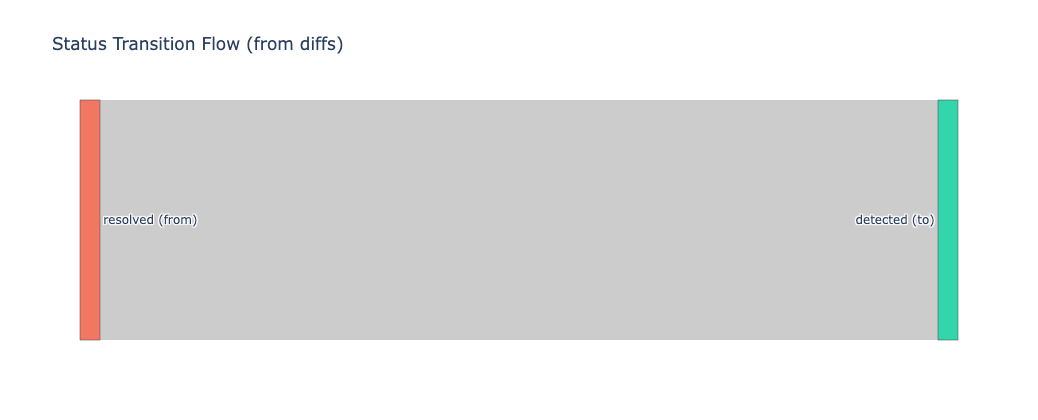

In [25]:
# --- Status transitions: Sankey diagram ---
if not diff_items.empty:
    status_changes = modified[modified["changed_fields"].apply(lambda x: "status" in x)].copy()
    if len(status_changes) > 0:
        status_changes["old_status"] = status_changes["field_changes"].apply(
            lambda fc: fc.get("status", {}).get("old", "unknown")
        )
        status_changes["new_status"] = status_changes["field_changes"].apply(
            lambda fc: fc.get("status", {}).get("new", "unknown")
        )
        flow = status_changes.groupby(["old_status", "new_status"]).size().reset_index(name="count")

        all_labels = sorted(set(flow["old_status"]) | set(flow["new_status"]))
        label_map = {lab: i for i, lab in enumerate(all_labels)}
        offset = len(all_labels)
        labels = [f"{l} (from)" for l in all_labels] + [f"{l} (to)" for l in all_labels]

        fig = go.Figure(go.Sankey(
            node=dict(label=labels, pad=15, thickness=20),
            link=dict(
                source=[label_map[r["old_status"]] for _, r in flow.iterrows()],
                target=[label_map[r["new_status"]] + offset for _, r in flow.iterrows()],
                value=flow["count"].tolist(),
            ),
        ))
        fig.update_layout(title="Status Transition Flow (from diffs)", height=420)
        fig.show()
    else:
        print("No status transitions detected.")

In [26]:
# --- Flapping vulnerabilities ---
if not diff_items.empty:
    add_remove = diff_items[diff_items["change_type"].isin(["added", "removed"])]
    flap_candidates = (
        add_remove.groupby(["row_key", "dataset_name"])["change_type"]
        .apply(lambda x: set(x))
        .reset_index(name="types")
    )
    flapping = flap_candidates[flap_candidates["types"] == {"added", "removed"}]

    if len(flapping) > 0:
        print(f"Flapping vulnerabilities (added + removed within observation window): {len(flapping)}")
        flap_detail = add_remove[add_remove["row_key"].isin(flapping["row_key"])]
        flap_timeline = (
            flap_detail.groupby("row_key")
            .apply(lambda g: "; ".join(f"{r['change_type']}:{r['to_date']}" for _, r in g.iterrows()))
            .reset_index(name="transitions")
        )
        flap_timeline.head(10)
    else:
        print("No flapping vulnerabilities detected — data is stable.")
else:
    print("No diff items available.")

No flapping vulnerabilities detected — data is stable.


## 7. Per-Asset Comparison

Compare vulnerability posture across tracked applications.

In [27]:
# --- Side-by-side summary table ---
def _asset_summary(grp):
    total = len(grp)
    crit = (grp["severity"] == "CRITICAL").sum()
    high = (grp["severity"] == "HIGH").sum()
    med = (grp["severity"] == "MEDIUM").sum()
    low = (grp["severity"] == "LOW").sum()
    info = (grp["severity"] == "INFO").sum()
    resolved_rate = (grp["status"] == "resolved").mean() if total > 0 else 0
    median_age = grp["age_days"].median() if "age_days" in grp.columns else None
    overdue_count = 0
    if "dueDate" in grp.columns:
        overdue_count = int((grp["dueDate"].dropna() < now).sum())
    return pd.Series({
        "Total": total,
        "Critical": crit,
        "High": high,
        "Medium": med,
        "Low": low,
        "Info": info,
        "Resolved %": f"{resolved_rate:.1%}",
        "Median Age (d)": f"{median_age:.0f}" if median_age is not None else "N/A",
        "Overdue": overdue_count,
    })

summary_table = df.groupby("dataset_name").apply(_asset_summary)
summary_table

,Total,Critical,High,Medium,Low,Info,Resolved %,Median Age (d),Overdue
dataset_name,,,,,,,,,
vulns-Consumer e-Banking Services (2466),14925,15,177,6739,4448,3546,43.6%,73,7770
vulns-Digital One Flex (17040),102620,8,1932,30062,66689,3929,81.6%,69,55602
vulns-Digital One LFI (12430),192744,4449,2883,25020,107390,53002,81.1%,160,119621


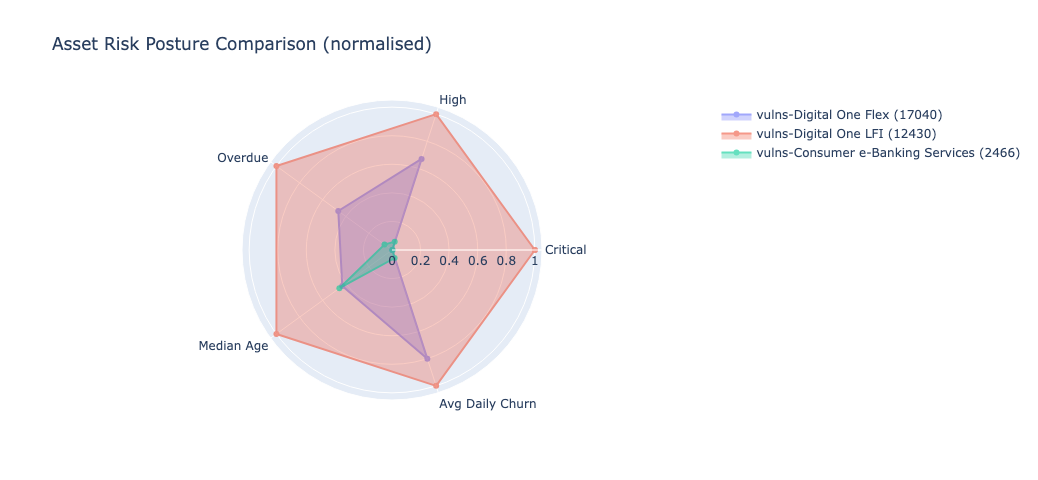

In [28]:
# --- Radar chart: comparative posture ---
assets = df["dataset_name"].unique()
if len(assets) >= 2:
    radar_metrics = []
    for asset in assets:
        grp = df[df["dataset_name"] == asset]
        crit = (grp["severity"] == "CRITICAL").sum()
        high = (grp["severity"] == "HIGH").sum()
        resolved_pct = (grp["status"] == "resolved").mean() * 100
        median_age = grp["age_days"].median() if "age_days" in grp.columns else 0
        overdue = 0
        if "dueDate" in grp.columns:
            overdue = int((grp["dueDate"].dropna() < now).sum())
        # Daily churn rate
        asset_diffs = diff_summaries[diff_summaries["dataset_name"] == asset] if not diff_summaries.empty else pd.DataFrame()
        avg_churn = 0
        if not asset_diffs.empty:
            avg_churn = (asset_diffs["added_count"] + asset_diffs["removed_count"] + asset_diffs["modified_count"]).mean()
        radar_metrics.append({
            "asset": asset,
            "Critical": crit,
            "High": high,
            "Overdue": overdue,
            "Median Age": median_age,
            "Avg Daily Churn": avg_churn,
        })

    radar_df = pd.DataFrame(radar_metrics).set_index("asset")
    # Normalise to 0-1 for radar comparability
    radar_norm = radar_df.div(radar_df.max(axis=0).replace(0, 1), axis=1)

    categories = list(radar_norm.columns)
    fig = go.Figure()
    for asset in radar_norm.index:
        vals = radar_norm.loc[asset].tolist()
        vals.append(vals[0])
        fig.add_trace(go.Scatterpolar(
            r=vals,
            theta=categories + [categories[0]],
            fill="toself",
            name=asset,
            opacity=0.6,
        ))

    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, 1.05])),
        title="Asset Risk Posture Comparison (normalised)",
        height=480,
    )
    fig.show()
else:
    print("Only one asset — radar comparison requires at least two.")

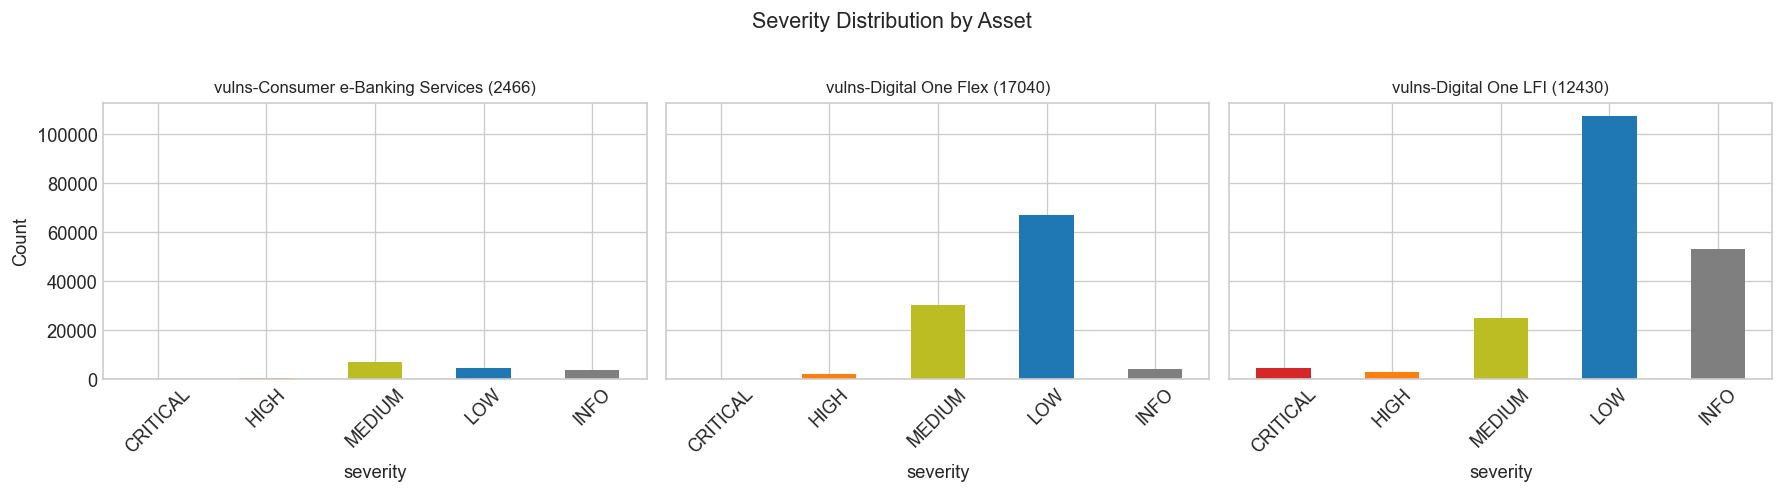

In [29]:
# --- Faceted severity distributions (small multiples) ---
if len(assets) >= 2:
    n_assets = len(assets)
    fig, axes = plt.subplots(1, n_assets, figsize=(5 * n_assets, 4), sharey=True)
    if n_assets == 1:
        axes = [axes]

    for ax, asset in zip(axes, sorted(assets)):
        grp = df[df["dataset_name"] == asset]
        sev = grp["severity"].value_counts().reindex(SEVERITY_ORDER).fillna(0)
        sev.plot.bar(
            ax=ax,
            color=[SEVERITY_COLORS[s] for s in sev.index],
        )
        ax.set_title(asset, fontsize=10)
        ax.set_ylabel("Count" if ax == axes[0] else "")
        ax.tick_params(axis="x", rotation=45)

    plt.suptitle("Severity Distribution by Asset", fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

## 8. Risk Scoring

Composite risk score per vulnerability:  
`risk = severity_weight × age_days × (1 + overdue_flag)`

Weights: CRITICAL=10, HIGH=7, MEDIUM=4, LOW=2, INFO=1

In [30]:
# --- Compute risk score ---
SEVERITY_WEIGHT = {"CRITICAL": 10, "HIGH": 7, "MEDIUM": 4, "LOW": 2, "INFO": 1}

open_df = df[df["status"].isin(["detected", "in_progress"])].copy()
open_df["sev_weight"] = open_df["severity"].map(SEVERITY_WEIGHT).fillna(1)
open_df["age_days"] = open_df["age_days"].fillna(0).clip(lower=1)
open_df["overdue_flag"] = 0
if "dueDate" in open_df.columns:
    open_df["overdue_flag"] = (open_df["dueDate"] < now).astype(int).fillna(0)

open_df["risk_score"] = open_df["sev_weight"] * open_df["age_days"] * (1 + open_df["overdue_flag"])

print(f"Open vulnerabilities scored: {len(open_df):,}")
print(f"Risk score range: {open_df['risk_score'].min():.0f} – {open_df['risk_score'].max():.0f}")
print(f"Mean risk score: {open_df['risk_score'].mean():.0f}")

TypeError: Object with dtype category cannot perform the numpy op multiply

In [31]:
# --- Top 25 highest-risk open vulnerabilities ---
display_cols = ["name", "severity", "status", "dataset_name", "age_days", "risk_score"]
if "location.fileName" in open_df.columns:
    display_cols.insert(3, "location.fileName")

top25 = open_df.nlargest(25, "risk_score")[display_cols].reset_index(drop=True)
top25.index = top25.index + 1
top25["age_days"] = top25["age_days"].round(0).astype(int)
top25["risk_score"] = top25["risk_score"].round(0).astype(int)
top25

KeyError: 'risk_score'

KeyError: 'Column not found: risk_score'

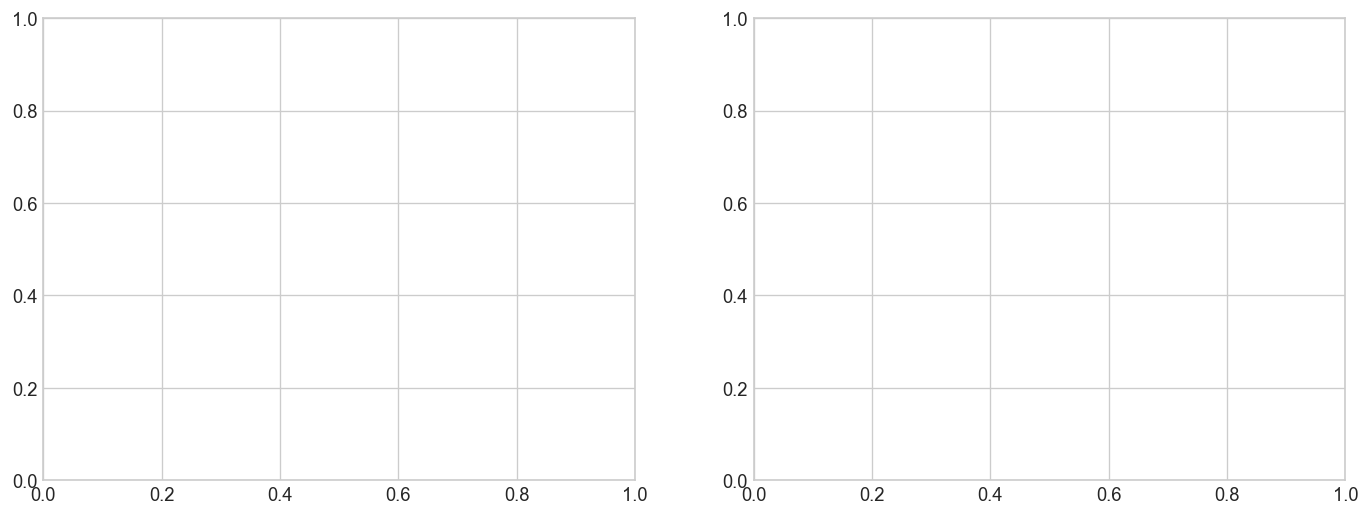

In [32]:
# --- Aggregate risk by asset and by file ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

risk_by_asset = open_df.groupby("dataset_name")["risk_score"].sum().sort_values(ascending=True)
risk_by_asset.plot.barh(ax=axes[0], color="#d62728")
axes[0].set_xlabel("Total Risk Score")
axes[0].set_title("Aggregate Risk by Asset")
for i, v in enumerate(risk_by_asset):
    axes[0].text(v + max(risk_by_asset) * 0.01, i, f"{v:,.0f}", va="center", fontsize=9)

if "location.fileName" in open_df.columns:
    risk_by_file = open_df.groupby("location.fileName")["risk_score"].sum().nlargest(10).sort_values(ascending=True)
    risk_by_file.plot.barh(ax=axes[1], color="#ff7f0e")
    axes[1].set_xlabel("Total Risk Score")
    axes[1].set_title("Top 10 Riskiest Files")
    for i, v in enumerate(risk_by_file):
        axes[1].text(v + max(risk_by_file) * 0.01, i, f"{v:,.0f}", va="center", fontsize=9)
else:
    axes[1].text(0.5, 0.5, "location.fileName not available", ha="center", va="center",
                 transform=axes[1].transAxes)

plt.tight_layout()
plt.show()

## 9. Executive Summary

Auto-generated findings from the analysis above.

In [33]:
# --- Build executive summary ---
from IPython.display import Markdown, display

lines = []
lines.append("### Key Findings\n")

# 1. Total counts
total = len(df)
crit = int((df["severity"] == "CRITICAL").sum())
high = int((df["severity"] == "HIGH").sum())
lines.append(f"- **Total vulnerabilities**: {total:,} across {df['dataset_name'].nunique()} assets")
lines.append(f"- **Critical + High**: {crit + high:,} ({(crit + high) / total:.1%} of total)")

# 2. Top 3 risk items
if len(open_df) > 0:
    top3 = open_df.nlargest(3, "risk_score")
    lines.append("\n**Top 3 highest-risk open vulnerabilities:**\n")
    for i, (_, row) in enumerate(top3.iterrows(), 1):
        lines.append(f"{i}. *{row['name']}* — {row['severity']}, {row['dataset_name']} "
                      f"(age {row['age_days']:.0f}d, score {row['risk_score']:.0f})")

# 3. MTTR by severity
if "closeDate" in df.columns:
    closed_for_mttr = df.dropna(subset=["closeDate", "openDate"]).copy()
    if len(closed_for_mttr) > 0:
        closed_for_mttr["mttr"] = (closed_for_mttr["closeDate"] - closed_for_mttr["openDate"]).dt.total_seconds() / 86400
        mttr_summary = closed_for_mttr.groupby("severity", observed=True)["mttr"].median().round(1)
        lines.append("\n**Median MTTR (days) by severity:**\n")
        for sev in SEVERITY_ORDER:
            if sev in mttr_summary.index:
                lines.append(f"- {sev}: {mttr_summary[sev]:.1f} days")

# 4. Trend direction
if not pop_trend.empty:
    latest_date = pop_trend["fetched_date"].max()
    earliest_date = pop_trend["fetched_date"].min()
    latest_total = pop_trend[pop_trend["fetched_date"] == latest_date]["row_count"].sum()
    earliest_total = pop_trend[pop_trend["fetched_date"] == earliest_date]["row_count"].sum()
    delta = latest_total - earliest_total
    direction = "increasing" if delta > 0 else ("decreasing" if delta < 0 else "stable")
    lines.append(f"\n**Trend**: Vulnerability count is **{direction}** "
                 f"({earliest_total:,} → {latest_total:,}, Δ{delta:+,} over observation window)")

# 5. Data quality flags
lines.append("\n**Data quality notes:**\n")
if "originatingSystemId" in df.columns:
    dup_ct = int(df["originatingSystemId"].dropna().duplicated().sum())
    if dup_ct > 0:
        lines.append(f"- ⚠ {dup_ct:,} duplicate `originatingSystemId` values detected")
    else:
        lines.append("- No duplicate `originatingSystemId` values")
null_rate = 1 - completeness.min()
worst_col = completeness.idxmin()
lines.append(f"- Least-complete column: `{worst_col}` ({completeness.min():.1%} non-null)")
if drift_cols:
    lines.append(f"- Schema drift in {len(drift_cols)} column(s): {sorted(drift_cols)}")
else:
    lines.append("- No schema drift across assets")

display(Markdown("\n".join(lines)))

KeyError: 'risk_score'